In [39]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pypsa.linopf import *
from pypsa.linopt import *

from pyomo.environ import Constraint

network = pypsa.Network()

network.snapshots = pd.date_range("2020-01-01 00:00", "2020-01-01 09:00", freq="H")

network.snapshots

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='H')

In [40]:
def extra_functionality(network, snapshots):
    model = network.model
    model.link_fix = Constraint(
        rule=lambda model: model.link_p_nom["Link2Store"]
        == model.link_p_nom["Link2Main"] * network.links.loc['Link2Main','efficiency']
    )

In [41]:
network.add("Bus", "Main", v_nom=380)
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
Main,380.0,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,


In [42]:
network.add(
    "Load", 
    name="TotalLoads", 
    bus="Main", 
    p_set=23000)
    # p_set=[25200,25200,25200,25200,25200,25200,25200,25200,25200,25200,])

In [43]:
network.loads_t

{'p_set': Empty DataFrame
 Columns: []
 Index: [2020-01-01 00:00:00, 2020-01-01 01:00:00, 2020-01-01 02:00:00, 2020-01-01 03:00:00, 2020-01-01 04:00:00, 2020-01-01 05:00:00, 2020-01-01 06:00:00, 2020-01-01 07:00:00, 2020-01-01 08:00:00, 2020-01-01 09:00:00],
 'q_set': Empty DataFrame
 Columns: []
 Index: [2020-01-01 00:00:00, 2020-01-01 01:00:00, 2020-01-01 02:00:00, 2020-01-01 03:00:00, 2020-01-01 04:00:00, 2020-01-01 05:00:00, 2020-01-01 06:00:00, 2020-01-01 07:00:00, 2020-01-01 08:00:00, 2020-01-01 09:00:00],
 'p': Empty DataFrame
 Columns: []
 Index: [2020-01-01 00:00:00, 2020-01-01 01:00:00, 2020-01-01 02:00:00, 2020-01-01 03:00:00, 2020-01-01 04:00:00, 2020-01-01 05:00:00, 2020-01-01 06:00:00, 2020-01-01 07:00:00, 2020-01-01 08:00:00, 2020-01-01 09:00:00],
 'q': Empty DataFrame
 Columns: []
 Index: [2020-01-01 00:00:00, 2020-01-01 01:00:00, 2020-01-01 02:00:00, 2020-01-01 03:00:00, 2020-01-01 04:00:00, 2020-01-01 05:00:00, 2020-01-01 06:00:00, 2020-01-01 07:00:00, 2020-01-01 08:0

In [44]:
network.add(
    "Generator", 
    name="TotalGenerators", 
    bus="Main", 
    p_nom=32500,
    #p_max_pu=[1,0.978593,0.948012,0.88685,0.8104,0.7034,0.6422,0.62691,0.61468,0.60856],
    p_max_pu=(6250*np.cos(np.linspace(0,9,num=10)*(np.pi/9))+26250)/32500,
    capital_cost=1.04*10**6,
    efficiency=1,
    marginal_cost=2.3,
    carrier="AC")

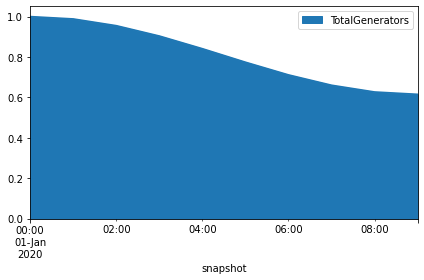

In [45]:
network.generators_t.p_max_pu.plot.area(subplots=True)
plt.tight_layout()

In [46]:
network.add("Bus", "StoreIsland", carrier="AC")
#parameterBank parameters = [Link 1 capital_cost, Link 1 efficiency, Link 2 capital_cost, Link 2 efficiency, Store capital costs]
parameterBank = [[0.2055  , 0.9     , 0.2055  , 0.9     , 0.192   ], #Lithium
       [0.35    , 0.8     , 0.35    , 0.58    , 0.01064 ], #H2
       [0.462238, 0.7211  , 0.633112, 0.7211  , 0.003477], #CAES
       [0.367   , 0.7746  , 0.367   , 0.7746  , 0.09437 ], #LAES
       [0.17766 , 0.6708  , 0.17766 , 0.6708  , 0.08883 ], #ETES
       [0.176515, 0.866   , 0.176515, 0.866   , 0.62289 ], #NaS
       [0.75    , 0.8944  , 0.75    , 0.8944  , 0.125   ]] #Fe-Flow
storeSeriesData = pd.DataFrame()
storeObjectives = [0 for a in range(7)]
storeCapacities = [0 for a in range(7)]
#columnNames = ['LIB','H2']

In [47]:
for i in range(7):
    #LINKS
    #Charger Link
    network.add(
        "Link",
        name="Link2Store",
        bus0="Main",
        bus1="StoreIsland",
        capital_cost=parameterBank[i][0]*10**6,
        p_nom_extendable=True,
        #marginal_cost=0,
        efficiency=parameterBank[i][1],
    )

    #Discharger Link
    network.add(
        "Link",
        name="Link2Main",
        bus0="StoreIsland",
        bus1="Main",
        capital_cost=parameterBank[i][2]*10**6,
        p_nom_extendable=True,
        #marginal_cost=0.01,
        efficiency=parameterBank[i][3]
    )

    #STORE
    network.add(
        "Store",
        "TheStorage",
        bus="StoreIsland",
        capital_cost=parameterBank[i][4]*10**6,
        e_nom_extendable=True,
        e_cyclic=True
    )

    if i==0 or i==5 or i==6:
        network.lopf(extra_functionality=extra_functionality)
    else:
        network.lopf()

    storeSeriesData = storeSeriesData.append(network.stores_t.e)
    storeObjectives[i] = network.objective
    storeCapacities[i] = network.stores_t.e.max()

    network.mremove("Store",["TheStorage"])
    network.mremove("Link",["Link2Main","Link2Store"])
    


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2829682281.86621
  Upper bound: 2829682281.86621
  Number of objectives: 1
  Number of constraints: 92
  Number of variables: 54
  Number of nonzeros: 183
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7145001888275146
# ----------------------------------------------------------
#   Solution Information
# ------------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_573/1753688968.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful
/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2862280261.26851
  Upper bound: 2862280261.26851
  Number of objectives: 1
  Number of constraints: 91
  Number of variables: 54
  Number of nonzeros: 181
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7183387279510498
# ----------------------------------------------------------
#   Solution Information
# ------------

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful
/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_573/1753688968.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3730458690.77235
  Upper bound: 3730458690.77235
  Number of objectives: 1
  Number of constraints: 91
  Number of variables: 54
  Number of nonzeros: 181
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7100765705108643
# ----------------------------------------------------------
#   Solution Information
# ------------

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful
/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_573/1753688968.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3016687818.88285
  Upper bound: 3016687818.88285
  Number of objectives: 1
  Number of constraints: 91
  Number of variables: 54
  Number of nonzeros: 181
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.7402160167694092
# ----------------------------------------------------------
#   Solution Information
# ------------

INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2227460076.22702
  Upper bound: 2227460076.22702
  Number of objectives: 1
  Number of constraints: 91
  Number of variables: 54
  Number of nonzeros: 181
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.8762130737304688
# ----------------------------------------------------------
#   Solution Information
# ------------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_573/1753688968.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 6292170713.3896
  Upper bound: 6292170713.3896
  Number of objectives: 1
  Number of constraints: 92
  Number of variables: 54
  Number of nonzeros: 183
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.9621889591217041
# ----------------------------------------------------------
#   Solution Information
# --------------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_573/1753688968.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 5766976635.2646
  Upper bound: 5766976635.2646
  Number of objectives: 1
  Number of constraints: 92
  Number of variables: 54
  Number of nonzeros: 183
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.9685726165771484
# ----------------------------------------------------------
#   Solution Information
# --------------

/home/sahiljotwani/anaconda3/envs/pypsa-eur/lib/python3.9/site-packages/pypsa/opf.py:1971: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat(
/tmp/ipykernel_573/1753688968.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storeSeriesData = storeSeriesData.append(network.stores_t.e)


In [48]:
storeSeriesData

Store,TheStorage
snapshot,
2020-01-01 00:00:00,2556.507388
2020-01-01 01:00:00,5256.507388
2020-01-01 02:00:00,7956.507388
2020-01-01 03:00:00,7956.507388
2020-01-01 04:00:00,7956.507388
...,...
2020-01-01 05:00:00,8006.324519
2020-01-01 06:00:00,8006.324519
2020-01-01 07:00:00,6286.984436


In [49]:
storeSeriesData2 = pd.DataFrame()
storeSeriesData2['Lithium'] = storeSeriesData.iloc[0:10]
storeSeriesData2['Hydrogen'] = storeSeriesData.iloc[10:20]
storeSeriesData2['CAES'] = storeSeriesData.iloc[20:30]
storeSeriesData2['LAES'] = storeSeriesData.iloc[30:40]
storeSeriesData2['ETES'] = storeSeriesData.iloc[40:50]
storeSeriesData2['NaS'] = storeSeriesData.iloc[50:60]
storeSeriesData2['Fe-Flow'] = storeSeriesData.iloc[60:]

storageCapacitiesdf= pd.DataFrame(storeCapacities)
storageCapacitiesdf = storageCapacitiesdf.set_axis(["Lithium", "Hydrogen","CAES","LAES","ETES","NaS","Fe-Flow"], axis=0)
storageCapacitiesdf = storageCapacitiesdf.set_axis(["Capacities"], axis=1)

storageObjectivesdf = pd.DataFrame(storeObjectives)
storageObjectivesdf = storageObjectivesdf.set_axis(["Lithium", "Hydrogen","CAES","LAES","ETES","NaS","Fe-Flow"], axis=0)
storageObjectivesdf = storageObjectivesdf.set_axis(["Objective"], axis=1)

In [50]:
storeSeriesData2

,Lithium,Hydrogen,CAES,LAES,ETES,NaS,Fe-Flow
snapshot,,,,,,,
2020-01-01 00:00:00,2556.507388,2102.909091,1655.872165,1524.626905,1827.833869,2598.000000,2639.924519
2020-01-01 01:00:00,5256.507388,4205.818183,3311.744330,3049.253810,3655.667737,5196.000000,5323.124519
2020-01-01 02:00:00,7956.507388,6308.727274,4967.616495,4573.880715,5483.501606,7794.000000,8006.324519
2020-01-01 03:00:00,7956.507388,8411.636365,6623.488661,6098.507621,7311.335474,8268.887586,8006.324519
2020-01-01 04:00:00,7956.507388,10514.545456,8279.360826,7623.134526,9139.169343,8268.887586,8006.324519
2020-01-01 05:00:00,7956.507388,12246.304568,9840.325195,9147.761431,10591.249358,8268.887586,8006.324519
2020-01-01 06:00:00,7956.507388,12346.304568,9930.462695,9244.586431,10675.099358,8268.887586,8006.324519
2020-01-01 07:00:00,6247.865422,9694.963586,7797.918291,7259.332404,8382.645915,6493.162679,6286.984436
2020-01-01 08:00:00,3333.333333,5172.413793,4160.310637,3872.966692,4472.271914,3464.203233,3354.203936


<AxesSubplot:xlabel='Time (hh:mm)', ylabel='Storage Capacity (MWh)'>

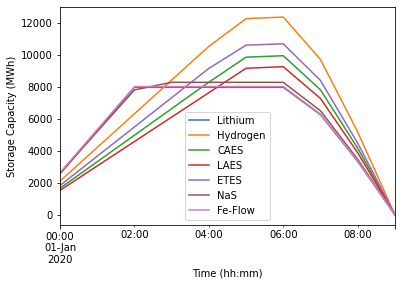

In [51]:
storeSeriesData2.plot(ylabel='Storage Capacity (MWh)', xlabel='Time (hh:mm)')

In [52]:
storageObjectivesdf

,Objective
Lithium,2.829682e+09
Hydrogen,2.862280e+09
CAES,3.730459e+09
LAES,3.016688e+09
ETES,2.227460e+09
NaS,6.292171e+09
Fe-Flow,5.766977e+09


In [53]:
storageObjectivesdf.values.min()*0.2


445492015.245404

<AxesSubplot:>

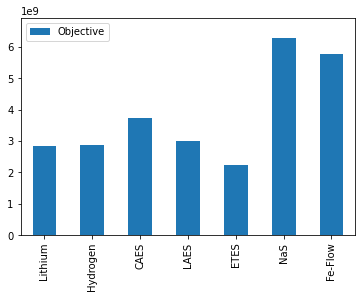

In [54]:
storageObjectivesdf.plot(kind="bar", 
    ylim=(storageObjectivesdf.values.min()*0,storageObjectivesdf.values.max()*1.10))

<AxesSubplot:>

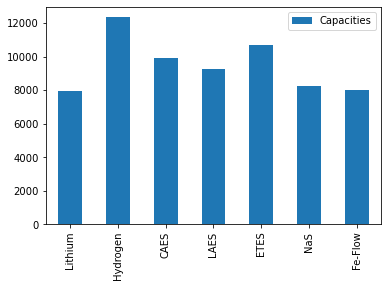

In [55]:
storageCapacitiesdf.plot(kind="bar")

In [56]:
# fig, (ax1, ax2) = plt.subplots(2,1)
# ax1.bar(storageObjectivesdf)